# Crop Yield Prediction: LSTM (Long Short-Term Memory)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import copy

# Tools for visualizing Optuna results
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Making the plots look a bit nicer
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Check if I have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cool, running on: {device}")

/Users/pavin/Documents/GitHub/ML_project/Final/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cool, running on: cpu


### 1. Loading Data & Picking the Target
Loading the dataset and picking which crop to predict. I'll stick with **Rice**, same as before.

In [2]:
# Load the data
df = pd.read_parquet('Parquet/XY_v3.parquet')

# --- CHECKING OPTIONS ---
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("Here are the available crops:")
print(available_crops)
print("-" * 40)

# --- CHOOSE CROP HERE ---
CHOSEN_CROP = 'rice'
# ---------------------------

TARGET_COL = f'Y_{CHOSEN_CROP}'

if TARGET_COL not in df.columns:
    raise ValueError(f"Can't find {TARGET_COL}. Check the spelling?")

print(f"Locked in target: {TARGET_COL}")

# Drop rows where the target is missing
df_model = df.dropna(subset=[TARGET_COL])
print(f"Valid data points found: {len(df_model)}")

Here are the available crops:
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Locked in target: Y_rice
Valid data points found: 4687


### 2. Cleaning & Prep
I'm keeping the cleaning process exactly the same as the Neural Network notebook to ensure a fair comparison. 

1. Remove extreme outliers per country.
2. Drop irrelevant columns.
3. **Split by time**: This time, I'll scale the full dataset first and *then* create sequences. This allows the Validation set to look back into the Training years for its initial sequences, so we don't lose data at the cut-off points.

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# --- DROP IRRELEVANT COLUMNS ---
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]
df_model = df_model.drop(columns=cols_to_drop)

# --- SETUP FEATURES ---
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

print(f"Total input features: {len(feature_cols)}")

# --- FILL MISSING VALUES (Full Dataset) ---
# We impute before split to ensure continuity, using mean strategy.
imputer = SimpleImputer(strategy='mean')
X_full_imputed = pd.DataFrame(imputer.fit_transform(df_model[feature_cols]), columns=feature_cols)

# --- NORMALIZE (SCALE) ---
# We fit scaler ONLY on training data to avoid data leakage, but transform everything.
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

train_idx = df_model[df_model['year'] < TRAIN_END_YEAR].index

scaler = StandardScaler()
scaler.fit(X_full_imputed.loc[train_idx])

X_full_scaled = scaler.transform(X_full_imputed)
df_features = pd.DataFrame(X_full_scaled, columns=feature_cols, index=df_model.index)

# --- LSTM SPECIFIC: CREATE SEQUENCES ---
# Reshape: (Samples, Features) -> (Samples, Seq_Len, Features)
SEQ_LEN = 5

def create_sequences_and_split(df_feats, df_meta, target_col, seq_len=5):
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []
    
    # We iterate by country to ensure sequences don't jump across borders
    # We use the ORIGINAL index to map features and targets correctly
    for area, group in df_meta.groupby('area'):
        group = group.sort_values('year')
        indices = group.index.values
        years = group['year'].values
        
        if len(group) < seq_len:
            continue
            
        # Sliding window across the FULL history of the country
        for i in range(len(group) - seq_len + 1):
            # Sequence input indices: i to i+seq_len-1
            # Target index: i+seq_len-1 (Predicting the LAST year in the sequence)
            
            seq_indices = indices[i : i + seq_len]
            target_idx = indices[i + seq_len - 1]
            target_year = years[i + seq_len - 1]
            
            # Grab data
            X_seq = df_feats.loc[seq_indices].values
            y_target = df_meta.loc[target_idx, target_col]
            
            # Assign to split based on TARGET YEAR
            if target_year < TRAIN_END_YEAR:
                X_train.append(X_seq)
                y_train.append(y_target)
            elif target_year < VAL_END_YEAR:
                X_val.append(X_seq)
                y_val.append(y_target)
            else:
                X_test.append(X_seq)
                y_test.append(y_target)
            
    return (
        np.array(X_train), np.array(y_train), 
        np.array(X_val), np.array(y_val), 
        np.array(X_test), np.array(y_test)
    )

print("Creating sequences...")
X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq = create_sequences_and_split(
    df_features, df_model, TARGET_COL, SEQ_LEN
)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).view(-1, 1).to(device)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1).to(device)

print(f"\nTraining samples (sequences): {len(X_train_seq)}")
print(f"Validation samples (sequences): {len(X_val_seq)}")
print(f"Test samples (sequences):       {len(X_test_seq)}")
print(f"Input Shape: {X_train_tensor.shape}")

Total input features: 17
Creating sequences...

Training samples (sequences): 2904
Validation samples (sequences): 534
Test samples (sequences):       514
Input Shape: torch.Size([2904, 5, 17])


### 3. First Try (Initial Model)
I'll define the LSTM architecture here. It uses an LSTM layer to capture time dependencies, followed by a fully connected (linear) head for the final regression output.

Epoch 0/100 -> Train RMSE: 3889.37 | Val RMSE: 4559.02
Epoch 20/100 -> Train RMSE: 700.76 | Val RMSE: 920.83
Epoch 40/100 -> Train RMSE: 469.99 | Val RMSE: 499.32
Epoch 60/100 -> Train RMSE: 421.18 | Val RMSE: 488.68
Epoch 80/100 -> Train RMSE: 398.56 | Val RMSE: 477.97
Epoch 99/100 -> Train RMSE: 358.19 | Val RMSE: 511.84


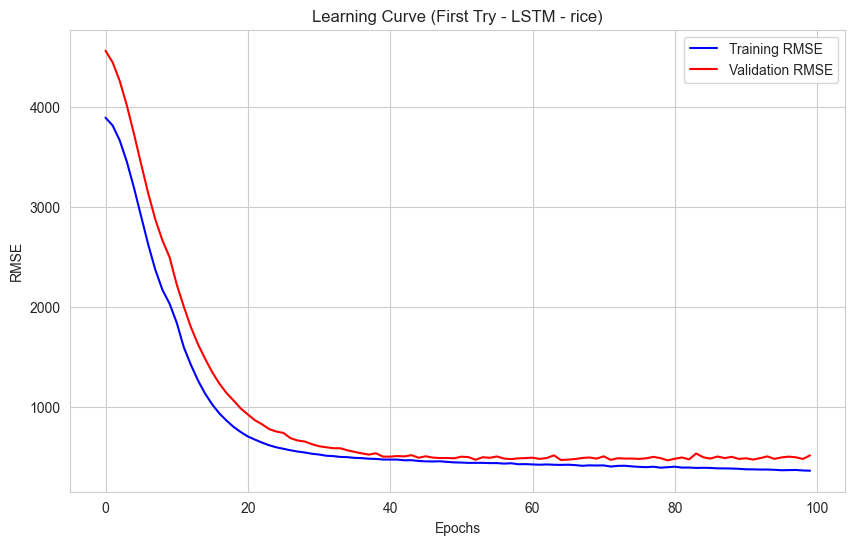


--- Initial LSTM Model Performance ---


,Metric,Train,Validation,Test
0,RMSE,332.682058,511.838689,568.102131
1,R²,0.968505,0.943973,0.931100


In [8]:
# --- DEFINE THE LSTM NETWORK ---
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2, activation="ReLU"):
        super(LSTMRegressor, self).__init__()
        
        # 1. LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        
        # 2. Output head: Linear -> Activation -> Linear
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            getattr(nn, activation)(),  # e.g. nn.ReLU(), nn.Tanh()
            nn.Linear(hidden_dim, 1),
        )
        
    def forward(self, x):
        # x: (batch, seq_len, features)
        out, _ = self.lstm(x)
        last_step_out = out[:, -1, :]    # We only care about the output of the last time step
        prediction = self.fc(last_step_out) 
        return prediction

# --- TRAINING HELPER FUNCTION ---
def train_model(model, X_t, y_t, X_v, y_v, lr=0.001, epochs=150, batch_size=32, verbose=True):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
            
        # Calculate metrics
        train_rmse = np.sqrt(epoch_loss / len(X_t))
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_v)
            val_loss = criterion(val_outputs, y_v)
            val_rmse = np.sqrt(val_loss.item())
            
        train_losses.append(train_rmse)
        val_losses.append(val_rmse)
        
        if verbose and (epoch % 20 == 0 or epoch == epochs-1):
            print(f"Epoch {epoch}/{epochs} -> Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}")
            
    return train_losses, val_losses

# --- RUNNING THE INITIAL MODEL ---
input_dim = X_train_tensor.shape[2]
model_init = LSTMRegressor(input_dim).to(device)

# Training with standard settings
train_hist, val_hist = train_model(model_init, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
                                   lr=0.001, epochs=100, batch_size=32)

# --- PLOTTING HISTORY ---
plt.figure(figsize=(10, 6))
plt.plot(train_hist, label='Training RMSE', color='blue')
plt.plot(val_hist, label='Validation RMSE', color='red')
plt.title(f'Learning Curve (First Try - LSTM - {CHOSEN_CROP})')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# --- EVALUATION TABLE ---
def get_metrics(model, X, y_true):
    model.eval()
    with torch.no_grad():
        preds = model(X).cpu().numpy().flatten()
    y_true_np = y_true
    # Handle tensor vs numpy
    if isinstance(y_true, torch.Tensor):
        y_true_np = y_true.cpu().numpy().flatten()
        
    rmse = np.sqrt(mean_squared_error(y_true_np, preds))
    r2 = r2_score(y_true_np, preds)
    return rmse, r2, preds

# Get stats for all sets
rmse_t, r2_t, _ = get_metrics(model_init, X_train_tensor, y_train_tensor)
rmse_v, r2_v, _ = get_metrics(model_init, X_val_tensor, y_val_tensor)
rmse_test, r2_test, preds_init_test = get_metrics(model_init, X_test_tensor, y_test_tensor)

# Show results
metrics_data = {
    'Metric': ['RMSE', 'R²'],
    'Train': [rmse_t, r2_t],
    'Validation': [rmse_v, r2_v],
    'Test': [rmse_test, r2_test]
}
print("\n--- Initial LSTM Model Performance ---")
display(pd.DataFrame(metrics_data))

### 4. Hyperparameter Tuning (Optuna)
Now I'll use Optuna to find the best configuration for the LSTM (Hidden dimensions, layers, dropout, learning rate).

In [5]:
# --- OBJECTIVE FUNCTION ---
def objective(trial):
    # Defining the search space
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    activation = trial.suggest_categorical("activation", ["ReLU", "Tanh"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Build model with these params
    model = LSTMRegressor(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout,
        activation=activation
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
        
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), 
                              batch_size=batch_size, shuffle=True)
    
    # Quick training loop
    epochs = 40 # Keeping epochs lower for speed during tuning
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Validate
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_rmse = np.sqrt(criterion(val_pred, y_val_tensor).item())

        # Pruning mechanism (stops bad trials early)
        trial.report(val_rmse, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_rmse

# --- START TUNING ---
study = optuna.create_study(direction='minimize', study_name='Crop_Yield_LSTM_Optuna')
study.optimize(objective, n_trials=30)

print("\nFound the best settings:")
print(study.best_params)

[I 2025-12-09 13:11:40,942] A new study created in memory with name: Crop_Yield_LSTM_Optuna
[I 2025-12-09 13:11:57,491] Trial 0 finished with value: 572.2161960308359 and parameters: {'hidden_dim': 96, 'num_layers': 3, 'dropout': 0.4195509324382397, 'lr': 0.001702813936246648, 'activation': 'ReLU', 'batch_size': 32}. Best is trial 0 with value: 572.2161960308359.
/Users/pavin/Documents/GitHub/ML_project/Final/.venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.253068910895501 and num_layers=1
  warnings.warn(
[I 2025-12-09 13:12:01,519] Trial 1 finished with value: 468.9411110416744 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.253068910895501, 'lr': 0.0028809275894673913, 'activation': 'ReLU', 'batch_size': 32}. Best is trial 1 with value: 468.9411110416744.
[I 2025-12-09 13:12:10,567] Trial 2 finished with 

KeyboardInterrupt: 

### 5. Optuna Visuals
Let's look at the charts to see how the optimization process went and which parameters mattered most.

In [ ]:
# Optimization History
fig = plot_optimization_history(study)
fig.show()

# Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.show()
except:
    print("Oops, couldn't plot importance.")

### 6. Training the Final Model
I'll take the best parameters from Optuna and train a fresh LSTM model. This time, I'll combine the Training and Validation sets to give the model maximum data before the final Test.

In [ ]:
# Combine Train and Validation Data (Sequences)
X_train_full = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_train_full = torch.cat((y_train_tensor, y_val_tensor), dim=0)

bp = study.best_params

final_model = LSTMRegressor(
    input_dim,
    hidden_dim=bp['hidden_dim'], 
    num_layers=bp['num_layers'], 
    dropout=bp['dropout'], 
    activation=bp['activation']
).to(device)

optimizer = optim.Adam(final_model.parameters(), lr=bp['lr'])
criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_train_full, y_train_full), 
                          batch_size=bp['batch_size'], shuffle=True)

print("Training the final version now...")
final_model.train()
for epoch in range(150):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

print("Finished!")

### 7. Results & Comparison
Let's see the numbers. I'll compare the Initial LSTM Model side-by-side with the Tuned LSTM Model.

In [ ]:
# Evaluate Final Model
rmse_f_t, r2_f_t, _ = get_metrics(final_model, X_train_tensor, y_train_tensor)
rmse_f_v, r2_f_v, _ = get_metrics(final_model, X_val_tensor, y_val_tensor)
rmse_f_test, r2_f_test, preds_final_test = get_metrics(final_model, X_test_tensor, y_test_tensor)

metrics_final = {
    'Metric': ['RMSE', 'R²'],
    'Train': [rmse_f_t, r2_f_t],
    'Validation': [rmse_f_v, r2_f_v],
    'Test': [rmse_f_test, r2_f_test]
}

print("--- Final Tuned LSTM Metrics ---")
display(pd.DataFrame(metrics_final))

# --- PLOT COMPARISON ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Convert y_test tensor back to numpy for plotting if needed
y_test_np = y_test_tensor.cpu().numpy().flatten()

all_preds = np.concatenate([preds_init_test, preds_final_test])
all_true = np.concatenate([y_test_np, y_test_np])
min_val, max_val = min(all_preds.min(), all_true.min()), max(all_preds.max(), all_true.max())

# Initial Model Plot
axes[0].scatter(y_test_np, preds_init_test, alpha=0.4, color='orange')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Initial LSTM\nTest RMSE: {rmse_test:.2f}')

# Tuned Model Plot
axes[1].scatter(y_test_np, preds_final_test, alpha=0.4, color='green')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Tuned LSTM\nTest RMSE: {rmse_f_test:.2f}')

plt.show()

In [ ]:
# --- TIMELINE PLOT ---
# We will reconstruct the timeline for the TEST set predictions.

# Re-extract years for the test sequences to be exact
# We iterate in the exact same order as sequence creation to match indices.
test_years_seq = []
for area, group in df_model.groupby('area'):
    group = group.sort_values('year')
    if len(group) < SEQ_LEN:
        continue
        
    indices = group.index.values
    years = group['year'].values
    
    for i in range(len(group) - SEQ_LEN + 1):
        target_year = years[i + SEQ_LEN - 1]
        if target_year >= VAL_END_YEAR:
            test_years_seq.append(target_year)

df_test_res = pd.DataFrame({
    'Year': test_years_seq,
    'Actual': y_test_tensor.cpu().numpy().flatten(),
    'Predicted': preds_final_test
})

# Aggregate
yearly_trend = df_test_res.groupby('Year').mean()

# Plot
plt.figure(figsize=(14, 7))
plt.plot(yearly_trend.index, yearly_trend['Actual'], marker='o', label='Actual Yield', linewidth=2, color='blue')
plt.plot(yearly_trend.index, yearly_trend['Predicted'], marker='x', linestyle='--', label='Predicted Yield', linewidth=2, color='orange')
plt.title(f'Test Period Analysis: Actual vs. Predicted Yield ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 8. Geographic Error Map
Which countries is the LSTM struggling with? Let's map out the errors.

In [ ]:
import plotly.express as px

# We need to map predictions back to countries. 
# Re-running the sequence generation logic just to get the Area list corresponding to y_test_tensor.
test_areas_seq = []

for area, group in df_model.groupby('area'):
    group = group.sort_values('year')
    if len(group) < SEQ_LEN:
        continue
    
    indices = group.index.values
    years = group['year'].values
    
    for i in range(len(group) - SEQ_LEN + 1):
        target_year = years[i + SEQ_LEN - 1]
        if target_year >= VAL_END_YEAR:
            test_areas_seq.append(area)

comparison_df = pd.DataFrame({
    'area': test_areas_seq,
    'Actual_Value': y_test_tensor.cpu().numpy().flatten(),
    'Predicted_Value': preds_final_test
})

# Clean names
comparison_df['area'] = comparison_df['area'].replace({
    'United_States_of_America': 'United States',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'China, mainland': 'China',
    'Republic_of_Korea': 'South Korea'
})

comparison_df['Squared_Error'] = (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) ** 2
comparison_df['Error_Pct'] = ((comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) / (comparison_df['Actual_Value'] + 1e-6)) ** 2

# Aggregate
map_data = comparison_df.groupby('area').agg(
    RMSPE=('Error_Pct', lambda x: np.sqrt(x.mean()) * 100),
    RMSE=('Squared_Error', lambda x: np.sqrt(x.mean())),
    Actual_Mean=('Actual_Value', 'mean'),
    Predicted_Mean=('Predicted_Value', 'mean')
).reset_index()

map_data.rename(columns={'area':'Country'}, inplace=True)

fig = px.choropleth(
    map_data,
    locations='Country',
    locationmode='country names',
    color='RMSPE',
    color_continuous_scale=['green', 'red'],
    range_color=[0, 50],
    title='Prediction Error by Country (LSTM RMSPE)',
    hover_data={'RMSPE': ':.2f', 'RMSE': ':.2f'}
)
fig.show()

### 9. Feature Importance
Calculating feature importance for LSTMs is complex because the inputs are 3D sequences. Standard Permutation Importance shuffles a feature across the whole dataset, which breaks the time-series continuity for that feature. 

For this section, I will skip the standard Permutation Importance plot to avoid misleading results or dimension errors, as `sklearn.inspection` expects 2D inputs.

In [ ]:
print("Feature importance analysis is skipped for the LSTM model due to 3D input structure compatibility issues with standard tools.")